In [1]:
import pennylane as qml
from qiskit.visualization import plot_bloch_vector
from pennylane import numpy as np
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import tensorflow as tf


# Basics 

## Qubit rotation

The idea behing this basic tutorial is to optimize the parameters to rotate $|0\rangle$ to $|1\rangle$.This is donde through 2 rotation gates, one in x(x is the axis of rotation) and another in y. $R_x(\phi_1)$ and $R_y(\phi_2)$.The parameters are $\phi_1$ and $\phi_2$.

1st Step: Initialize de the Device(an object that performs the operations and measurements on the wires, subsystems)

In [2]:
dev1 = qml.device("default.qubit", wires=1)

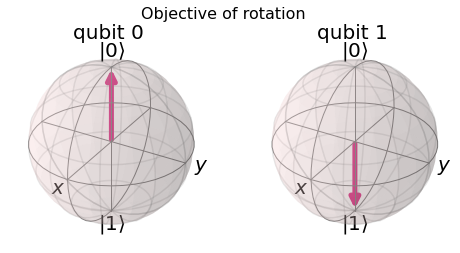

In [3]:
qc = QuantumCircuit(2)
qc.x(1)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="Objective of rotation", reverse_bits=False)

*Notation*:
**Device**: the hardware or simulated machine that will execute the operations and measurements
**Wire**:subsystem that in most cases is a **qubit** in CV devices it is a quantum mode
**Qnode**: It contains both devices as well as the functions defined for the specific circuit. It has the information on how the operations should be done (the q-functions), and who should do it  (the device).
From this notation and structuring within PennyLane it is then clear that we need not only define a device in which to perform this operations but also what operations or functions to perform, so that is the next step:

2nd Step

In [4]:
def circuit(params):#it accepts parameters as any other python function
    qml.RX(params[0], wires=0)#it performs quantum operations, on the specified wire
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))#it always returns a classical value, in this case this is done through projecting on z and then measuring

3rd step use decorators to extent the functions so far defined to the circuit() function,why would this be helpful? because every time we want to use a node (say in a graph) we would have to call the circuit and that would be it.

In [5]:
@qml.qnode(dev1)
def circuit(params):#this function get's "decorated" meaning this is the core
    qml.RX(params[0], wires=0)#but it has another functionality
    qml.RY(params[1], wires=0)#which is using this wires on the device
    return qml.expval(qml.PauliZ(0))

In [6]:
dcircuit = qml.grad(circuit, argnum=0)#Gradient that will be used to perform gradient descent, go to the direction of minimum indicated by the gradient


In [7]:
def cost(x):
    return circuit(x)# as we want to minimize circuit(x) and the values are bounded between [-1,1] then the cost function can directly be this one
# in other words the minimum value coincides with the value that we need
init_params = np.array([0.011, 0.012])#initial guesses
print(cost(init_params))#how far are we ? if close to 1 we are far u.u

0.9998675058299389


In [8]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)#built in optimizer,stepsize would be a hyperparameter

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)#updated using cost

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))#after 40 steps we have the desired value!

Cost after step     5:  0.9961778
Cost after step    10:  0.8974944
Cost after step    15:  0.1440490
Cost after step    20: -0.1536720
Cost after step    25: -0.9152496
Cost after step    30: -0.9994046
Cost after step    35: -0.9999964
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [7.15266381e-18 3.14159265e+00]


## Gaussian Transformation

Used mainly for continuous variable devices such as photonic devices. I see it as a combination as the last example (rotations) and adding a displacement component.First we'll start with a vacuum state $|0\rangle$ and then we'll displace it to be centered in $\alpha$ in phase space.then instead of a displacemente in phase space we perform a rotation $\phi$.Then the aim is to obtain an average number of photon of 1, we want to optimize the system such that we have that case.

In [9]:
dev_gaussian = qml.device("default.gaussian", wires=1)#same as before define a device
@qml.qnode(dev_gaussian)
def mean_photon_gaussian(mag_alpha, phase_alpha, phi):
    qml.Displacement(mag_alpha, phase_alpha, wires=0)
    qml.Rotation(phi, wires=0)
    return qml.expval(qml.NumberOperator(0))
def cost(params):
    return (mean_photon_gaussian(params[0], params[1], params[2]) - 1.0) ** 2 #the cost is the square difference optimal Value would be 0
init_params = [0.015, 0.02, 0.005]#initial guess
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 20
# set the initial parameter values
params = init_params

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    print("Cost after step {:5d}: {:8f}".format(i + 1, cost(params)))

print("Optimized mag_alpha:{:8f}".format(params[0]))
print("Optimized phase_alpha:{:8f}".format(params[1]))
print("Optimized phi:{:8f}".format(params[2]))

Cost after step     1: 0.999118
Cost after step     2: 0.998273
Cost after step     3: 0.996618
Cost after step     4: 0.993382
Cost after step     5: 0.987074
Cost after step     6: 0.974837
Cost after step     7: 0.951332
Cost after step     8: 0.907043
Cost after step     9: 0.826649
Cost after step    10: 0.690812
Cost after step    11: 0.490303
Cost after step    12: 0.258845
Cost after step    13: 0.083224
Cost after step    14: 0.013179
Cost after step    15: 0.001001
Cost after step    16: 0.000049
Cost after step    17: 0.000002
Cost after step    18: 0.000000
Cost after step    19: 0.000000
Cost after step    20: 0.000000
Optimized mag_alpha:0.999994
Optimized phase_alpha:0.020000
Optimized phi:0.005000


##  Hybrid computation

The aim here is to take the initial state of two wires $|1,0\rangle $ and pass them through a beam splitter such that having a transmission amplitude of $cos\theta$ and reflection amplitude $e^{i\phi}sin\theta$ we obtain at the end the state $|0,1\rangle $ that is such that the expected value of photons in the second wire is maximized.
Analitically the expected value maximization is independent of the chosen $\phi$ and is maximum for $\theta=(2m+1)\pi/2$

In [10]:
dev_fock = qml.device("strawberryfields.fock", wires=2, cutoff_dim=2)

They used StrawberryFields supposedly to make it easier for the circuit to be implemented in other devices, I don't see the benefit right away, I don't understand quite well why we would need to add this library and work from it. Maybe in more advanced lessons I'll get it.But i think it also has to do with all the plugins stuff, meaning we have our basic code in pennylane, then we can integrate it to other environments easily by adding plugins, for example qiskit.I didn't know that, that's why I imported it separatedly above.


In [11]:
@qml.qnode(dev_fock, diff_method="parameter-shift")
def photon_redirection(params):
    qml.FockState(1, wires=0)#now operations are CV operations meaning we are dealing with variables such as with optics, here
    qml.Beamsplitter(params[0], params[1], wires=[0, 1])
    return qml.expval(qml.NumberOperator(1))
#just as before but now using the device on strawberryfield, we use a decorator on the function that we want every Qnode to
#perform

Continuous variable-->like analog.Infinite dimensional Hilbert space
qubits--->like digital.Finite Dimensional Hilbert space

In [12]:
def cost(params):
    return -photon_redirection(params) #we wish to maximize mean photon number of the second wire 
#cost function to minimize the negative of the output.
init_params = np.array([0.01, 0.01]) #initialize in small guesses

The initial values are close to 0 so the BeamSplitter transmits all of it , having 0 reflection, like an identity operation.they chose values close to 0 but not 0 exactly becqause there the gradient also is 0 so trakign steps of gradient 0 leads to--->No movement, so we wouldn't get there ever.(being in maximum, we stay there u.u)

In [13]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)#using gradient descent as before

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5: -0.0349558
Cost after step    10: -0.9969017
Cost after step    15: -1.0000000
Cost after step    20: -1.0000000
Cost after step    25: -1.0000000
Cost after step    30: -1.0000000
Cost after step    35: -1.0000000
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [1.57079633 0.01      ]


It is optimized to a good extent at only 15 steps! and numerically is what we expected the first value is $\pi/2$ and the other parameter doesn't change because it has no effect on the gradient descent process(it makes sense i guess, because we only have one beam comming out reflected, so the phase shift between transmited and reflected is not relevant)

In [14]:
# create the devices
dev_qubit = qml.device("default.qubit", wires=1)
dev_fock = qml.device("strawberryfields.fock", wires=2, cutoff_dim=10)


@qml.qnode(dev_qubit)
def qubit_rotation(phi1, phi2):
    """Qubit rotation QNode"""
    qml.RX(phi1, wires=0)
    qml.RY(phi2, wires=0)
    return qml.expval(qml.PauliZ(0))


@qml.qnode(dev_fock, diff_method="parameter-shift")
def photon_redirection(params):
    """The photon redirection QNode"""
    qml.FockState(1, wires=0)
    qml.Beamsplitter(params[0], params[1], wires=[0, 1])
    return qml.expval(qml.NumberOperator(1))


def squared_difference(x, y):
    """Classical node to compute the squared
    difference between two inputs"""
    return np.abs(x - y) ** 2
#now combine the rotation qubit qith the CV circuit, we are going to use the squared difference of this 2 outputs, this is the loss fucntion

They are basically optimizing the $BS(\theta,\phi)$ parameters to adjust to the rotation gate used in qubits, like adjusting analog to digital i guess.they adjust the values of the rotation so with the given $\phi_1=0.5, \phi_2=0.1$ which will be a fixed value we will optimize the BS circuit

In [15]:
def cost(params, phi1=0.5, phi2=0.1):
    """Returns the squared difference between
    the photon-redirection and qubit-rotation QNodes, for
    fixed values of the qubit rotation angles phi1 and phi2"""
    qubit_result = qubit_rotation(phi1, phi2)
    photon_result = photon_redirection(params)
    return squared_difference(qubit_result, photon_result)#the cost function as defined above applied to the two circuits

In [16]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
params = np.array([0.01, 0.01])

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5:  0.2154539
Cost after step    10:  0.0000982
Cost after step    15:  0.0000011
Cost after step    20:  0.0000000
Cost after step    25:  0.0000000
Cost after step    30:  0.0000000
Cost after step    35:  0.0000000
Cost after step    40:  0.0000000
Cost after step    45:  0.0000000
Cost after step    50:  0.0000000
Cost after step    55:  0.0000000
Cost after step    60:  0.0000000
Cost after step    65:  0.0000000
Cost after step    70:  0.0000000
Cost after step    75:  0.0000000
Cost after step    80:  0.0000000
Cost after step    85:  0.0000000
Cost after step    90:  0.0000000
Cost after step    95:  0.0000000
Cost after step   100:  0.0000000
Optimized rotation angles: [1.20671364 0.01      ]


In [17]:
result = [1.20671364, 0.01]
print(photon_redirection(result))
print(qubit_rotation(0.5, 0.1))


0.8731983021146449
0.8731983044562817


As seen above the two circuits print the same result! the objective was met

## Quantum gradients with backpropagation

Parameter-shift-rule basic idea: computing gradients with the circuit function by making a linear superposition of other quantum functions that are the same circuit funcitons differing by a shift of the argument.this is true for the calculation of back propagation in real harware, which is basically treated as a blackbox, we dont really know exactly whats going on inside, we just have inputs and outputs.but with simulations awe do know exactly so we want to compare backpropagation to the parameter shift rule, comparing methods basically

In [18]:
# set the random seed
np.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)
#define the circuit to which to apply ParameterShift rule(PSR)
@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))
# initial parameters
params = np.random.random([6])
#use random parameters
print("Parameters:", params)
print("Expectation value:", circuit(params))
def parameter_shift_term(qnode, params, i):#gradient with respect to the ith parameter
    shifted = params.copy()
    shifted[i] += np.pi/2#shift by this factor
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))    #as said calculated in the tutorial, the expectation value of the
#shifted terms is the gradient of the expectation value of the circuit

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871565
-0.06518877224958125


In [19]:
def parameter_shift(qnode, params):# gradient with respect to all the parameters
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  4.16333634e-17]


It requires $2p$ calculations to perform with p being the number or parameters. reverse-mode autodifferentiation takes only p so half the amount of calculations performed, but it has higher memory usage, backpropagation is a particular case of reverse mode autodiffferentiation."while reverse-mode autodifferentiation works fine for small quantum simulations, only the parameter-shift rule can be used to compute gradients on quantum hardware directly" backprop is not compatible to the quantum structure, we use instead reversemode autodifferentiation.

In [24]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev, diff_method="backprop", interface="tf")#Backprop is used only for certain circuit such as default.qubit
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)#strongly entangled layers, as an example for a more complicated example
params = tf.Variable(params)#using tensorflow
print(circuit(params))

tf.Tensor(0.9537588703992619, shape=(), dtype=float64)


In [25]:
import timeit#for the backprop method

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}) for backprop: {forward_time} sec per loop")


Forward pass (best of 3) for backprop: 0.2919446500000021 sec per loop


Time comparasion. 

In [ ]:
dev = qml.device("default.qubit", wires=4)#must initialize circuit again, apparently  i think it's because i measured it already

def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))
reps = 2
num = 3

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, 21):
    params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=depth)
    num_params = params.size
    params = tf.Variable(params)

    # forward pass timing
    # ===================

    qnode_shift = qml.QNode(circuit, dev, interface="tf", diff_method="parameter-shift", mutable=False)
    qnode_backprop = qml.QNode(circuit, dev, interface="tf", diff_method="backprop", mutable=False)

    # parameter-shift
    t = timeit.repeat("qnode_shift(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qnode_backprop(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============

    qnode_shift = qml.QNode(circuit, dev, interface="tf", diff_method="parameter-shift", mutable=False)
    qnode_backprop = qml.QNode(circuit, dev, interface="tf", diff_method="backprop", mutable=False)

    # parameter-shift
    with tf.GradientTape(persistent=True) as tape:
        res = qnode_shift(params)

    t = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    with tf.GradientTape(persistent=True) as tape:
        res = qnode_backprop(params)

    t = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

In [ ]:
from matplotlib import pyplot as plt
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()